In [46]:
# Import packages
import math
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as pltz
from matplotlib import pyplot as plt
from sklearn import preprocessing as pp
from statsmodels.tsa.stattools import adfuller
import seaborn as sns # statistical visualisation
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set() # to have nore appealing visualisations

In [47]:
# Helper function: Prints out the data description and returns the head of the data
def data_describe(data):
    print(data.describe())
    return data.head()

In [48]:
# This function takes file name at a given location
# Returns dataframe corresponding to data in file
def read_file(company_symbol = 'AAPL'):
    column_names = [
                    'INDEX', 'DATE', 'OPEN', 
                    'HIGH', 'LOW', 'CLOSE',
                    'ADJ_CLOSE', 'VOLUME', 
                    'DIV_AMT', 'SPLIT_COEFF'
                   ]
#     filepath = '../data/alphaVantage/AAPL-full-daily_adjusted.csv'
    filepath = '../data/alphaVantage/' + company_symbol + '-full-daily_adjusted.csv'
#     print('Getting File from: ', filepath)
    df = pd.read_csv(filepath, skiprows=1, header=None, names=column_names, index_col=['DATE'], parse_dates=['DATE'])
    df.drop(columns=['INDEX'], inplace=True)
    return df

company_symbol = 'AAPL'
stocks = read_file(company_symbol)
print(stocks.info())
stocks.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5235 entries, 2018-10-19 to 1998-01-02
Data columns (total 8 columns):
OPEN           5235 non-null float64
HIGH           5235 non-null float64
LOW            5235 non-null float64
CLOSE          5235 non-null float64
ADJ_CLOSE      5235 non-null float64
VOLUME         5235 non-null int64
DIV_AMT        5235 non-null float64
SPLIT_COEFF    5235 non-null float64
dtypes: float64(7), int64(1)
memory usage: 368.1 KB
None


,OPEN,HIGH,LOW,CLOSE,ADJ_CLOSE,VOLUME,DIV_AMT,SPLIT_COEFF
DATE,,,,,,,,
2018-10-19,218.06,221.26,217.4300,219.31,219.31,33078726,0.0,1.0
2018-10-18,217.86,219.74,213.0000,216.02,216.02,32581315,0.0,1.0
2018-10-17,222.30,222.64,219.3400,221.19,221.19,22885397,0.0,1.0
2018-10-16,218.93,222.99,216.7627,222.15,222.15,29183963,0.0,1.0
2018-10-15,221.16,221.83,217.2700,217.36,217.36,30791007,0.0,1.0


In [90]:
# This function plots the parameter specified for a given dataframe
def visualise_plot(df, param, title):
    df[param].plot(figsize=(20,10), fontsize=20)
    plt.xlabel('Year', fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()

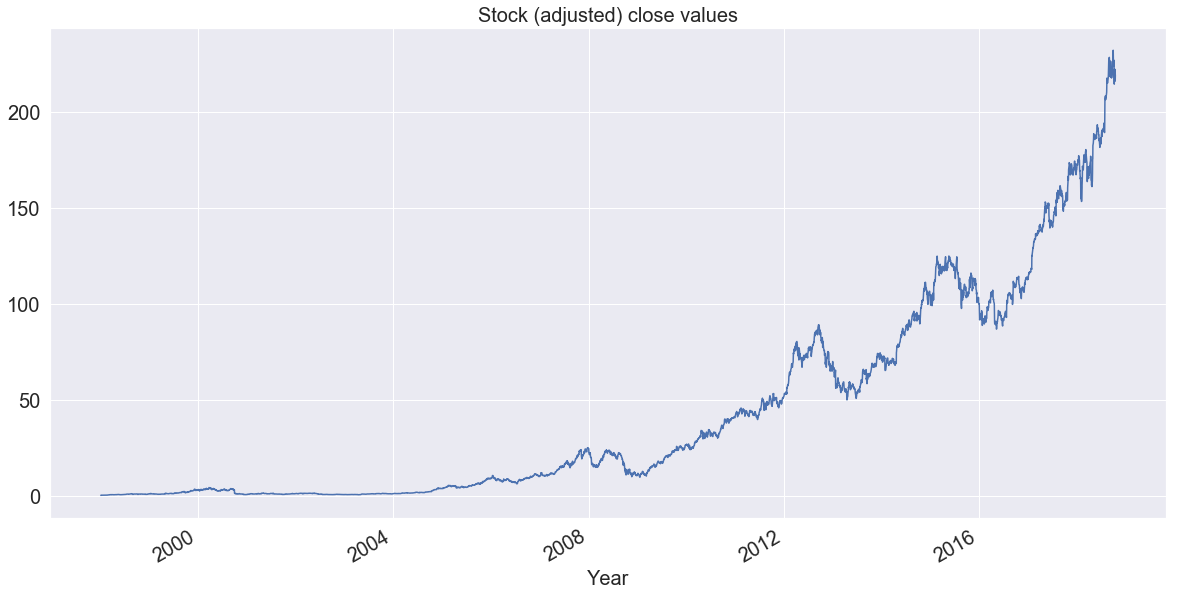

In [50]:
visualise_plot(stocks, 'ADJ_CLOSE', 'Stock (adjusted) close values')

## Converting to Returns

In [51]:
# This function returns the daily returns of the stock based on a specified parameter within the data (Using Taylor series approximation)
def data_daily_returns(data, param = 'ADJ_CLOSE'):
    daily_returns = list()
    date = list()
    for i in range(len(data) - 1):
        abs_t1 = math.log10(data.loc[data.index[i], param])
        abs_t0 = math.log10(data.loc[data.index[i + 1], param])
        daily_returns.append(abs_t1 - abs_t0)
        date.append(data.index[i])
    return pd.DataFrame(daily_returns, index=date, columns=['RETURNS'])

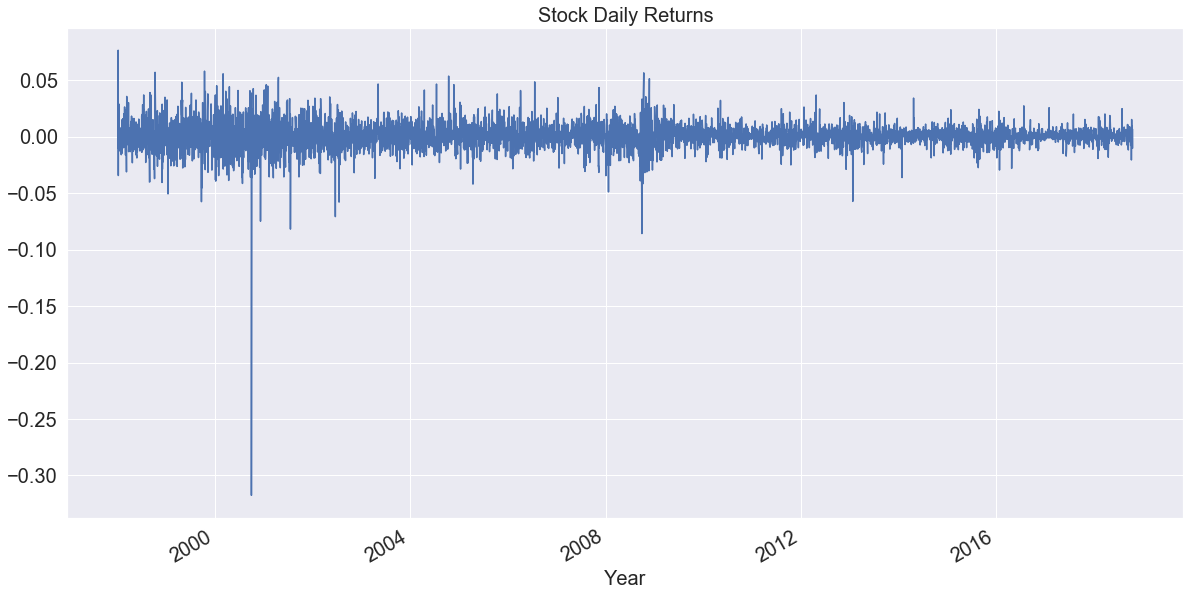

           RETURNS
count  5234.000000
mean      0.000502
std       0.012120
min      -0.317576
25%      -0.004821
50%       0.000413
75%       0.006050
max       0.076567


,RETURNS
2018-10-19,0.006564
2018-10-18,-0.010272
2018-10-17,-0.001881
2018-10-16,0.009467
2018-10-15,-0.009388


In [89]:
stock_returns = data_daily_returns(stocks, 'ADJ_CLOSE')
visualise_plot(stock_returns, 'RETURNS', 'Stock Daily Returns')
data_describe(stock_returns)

## Scaling
### 1. Standard Scaling

In [53]:
# This function performs Standard Scaling on the data to get 0 mean and 1 Standard Deviation
def standard_scaling_data(data):
    temp = data
    standardScaler = pp.StandardScaler()
    column_names = temp.columns
    standardScaler.fit(temp)
    data = pd.DataFrame(standardScaler.transform(temp), 
                        index=data.index, 
                        columns = column_names)
    return data

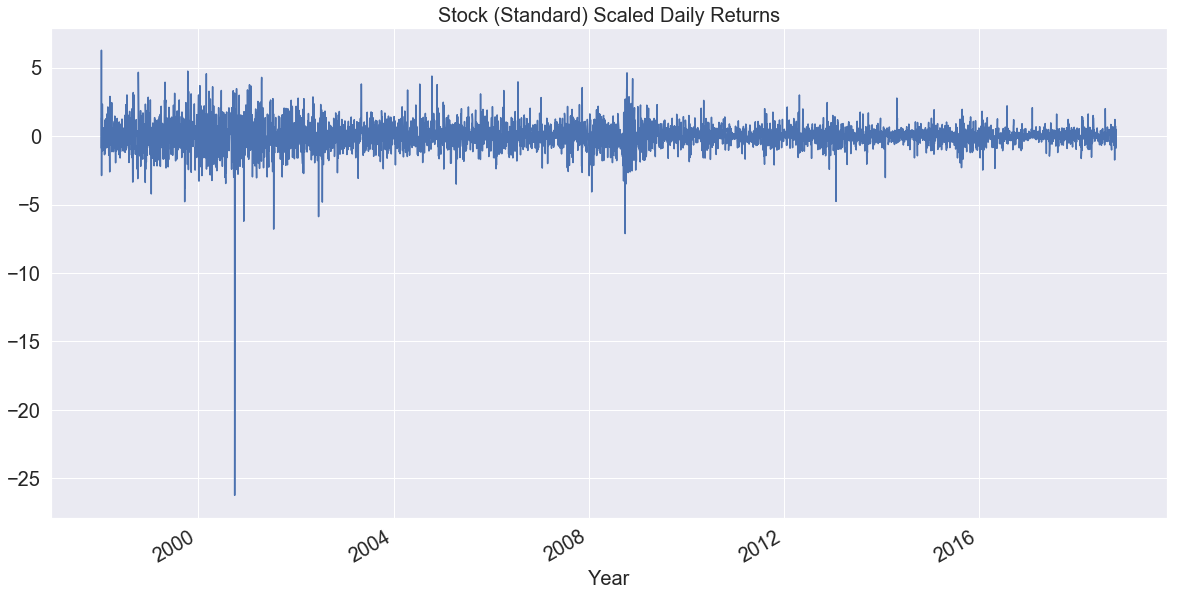

            RETURNS
count  5.234000e+03
mean  -1.378764e-18
std    1.000096e+00
min   -2.624558e+01
25%   -4.392844e-01
50%   -7.387970e-03
75%    4.577712e-01
max    6.276277e+00


,RETURNS
2018-10-19,0.500194
2018-10-18,-0.888992
2018-10-17,-0.196651
2018-10-16,0.739665
2018-10-15,-0.816130


In [54]:
std_scaled_stock_returns = standard_scaling_data(stock_returns)
visualise_plot(std_scaled_stock_returns, 'RETURNS', 'Stock (Standard) Scaled Daily Returns')
data_describe(std_scaled_stock_returns)

### 2. Min-Max Scaling

In [55]:
# This function performs Min-Max Scaling on the data to scale the data between a certain minimum and maximum
def min_max_scaling_data(data, min, max):
    temp = data
    minMaxScaler = pp.MinMaxScaler(feature_range=(min,max))
    column_names = temp.columns
    temp = minMaxScaler.fit_transform(temp)
    data = pd.DataFrame(temp, index=data.index, columns = column_names)
    return data

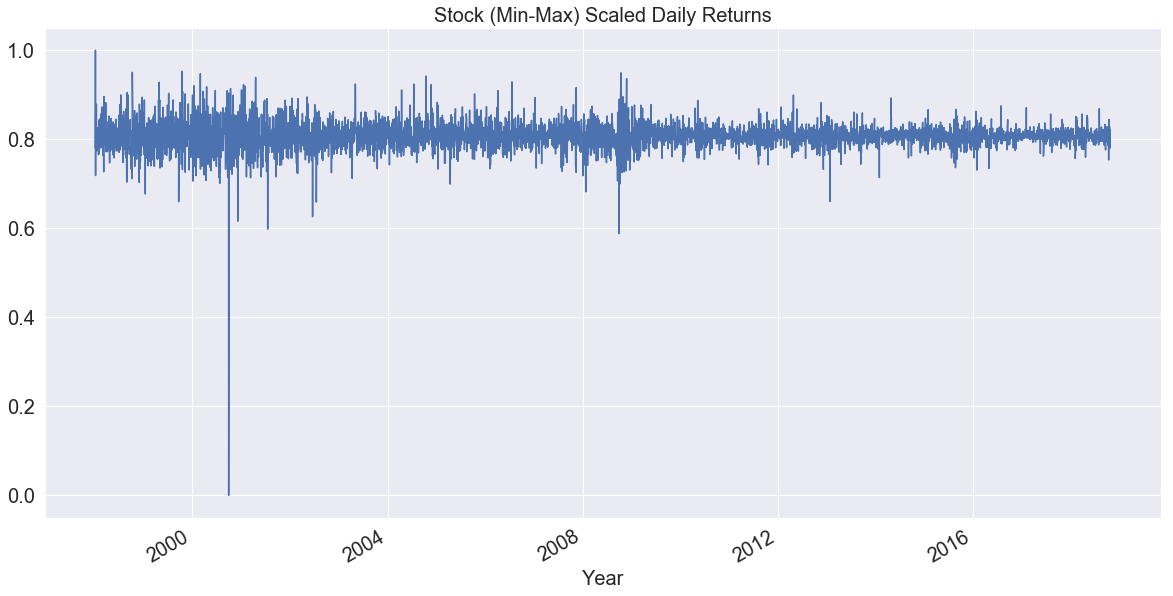

           RETURNS
count  5234.000000
mean      0.807014
std       0.030751
min       0.000000
25%       0.793506
50%       0.806786
75%       0.821089
max       1.000000


,RETURNS
2018-10-19,0.822394
2018-10-18,0.779678
2018-10-17,0.800967
2018-10-16,0.829757
2018-10-15,0.781919


In [56]:
minmax_scaled_stock_returns = min_max_scaling_data(stock_returns, 0, 1)
visualise_plot(minmax_scaled_stock_returns, 'RETURNS', 'Stock (Min-Max) Scaled Daily Returns')
data_describe(minmax_scaled_stock_returns)

## Decomposition
### 1. Rolling Average Trend

In [86]:
# This function plots the rolling average trend for a given dataframe and parameter
# Default window size of 252 days rolling around a year (Number of trading days in a year = 252)
def plot_rolling_average_trend(df, decomposition_param, window = 252):
    df[decomposition_param].rolling(window).mean().plot(figsize=(20,10), linewidth=2, fontsize=20) 
    # plotting the trend
    plt.title("Rolling Average Trend", fontsize=20)
    plt.xlabel('Year', fontsize=20);
    plt.savefig('Images/AAPL/AAPL_differencing.png')
#     plt.show()

In [58]:
# This function plots the dataframe after trend removal using rolling mean
def plot_detrended_rolling_average(df, decomposition_param):
    daily_returns = df[decomposition_param]
    # Removing the trend (to see the seasonality and noise)
    daily_returns_detrend = daily_returns.diff()
    daily_returns_detrend.plot(figsize=(20,10), fontsize=20)
    plt.title('Data: Seasonality + Residue (Trend Rolling Mean)', fontsize=20)
    plt.xlabel('Year', fontsize=20);
    plt.show()

    # Scatter Plot
    plt.figure(figsize=(20, 10))
    plt.scatter(daily_returns.index, daily_returns_detrend)
    plt.title('Data: Seasonality + Residue (Trend Rolling Mean)', fontsize=20)
    plt.xlabel('Year', fontsize=20);

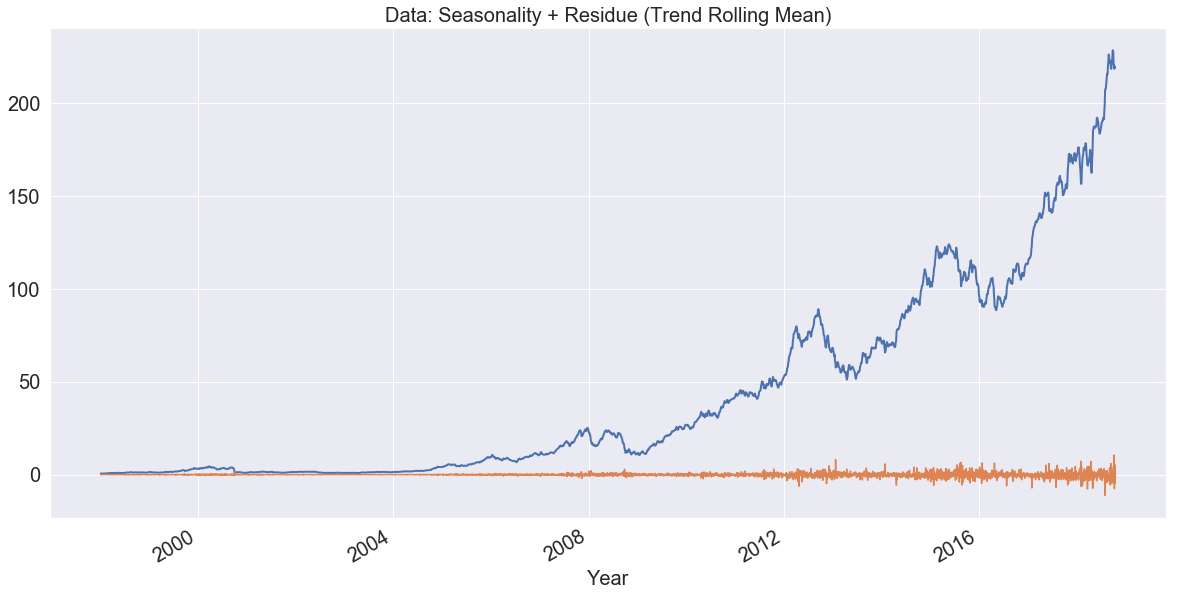

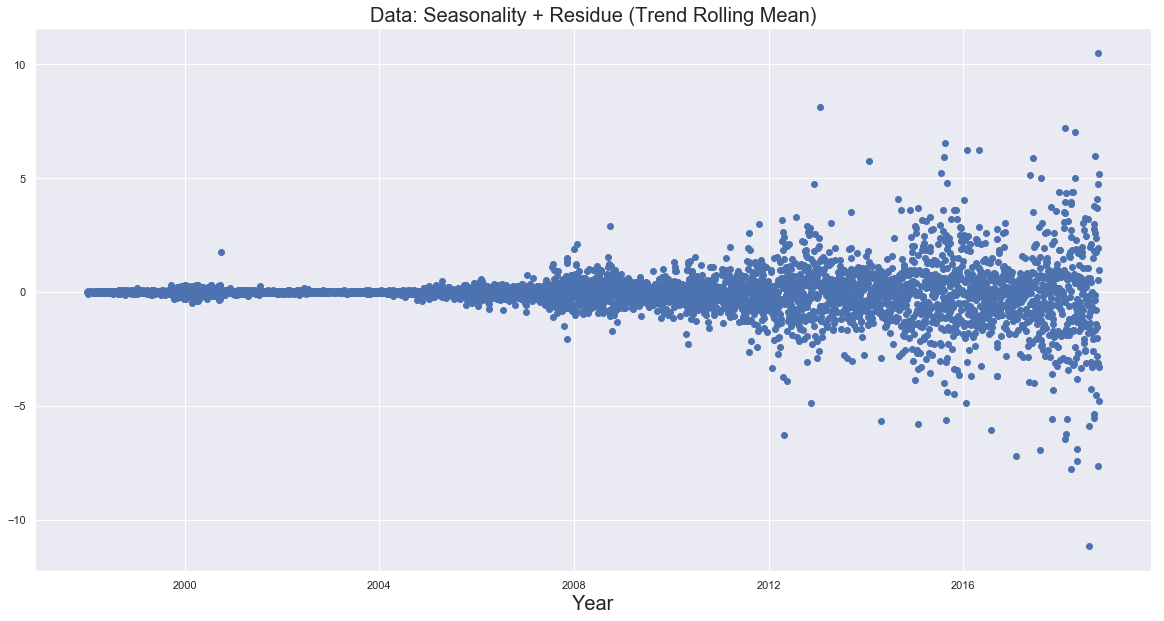

In [87]:
df = stocks
decomposition_param = 'ADJ_CLOSE'

# df = stock_returns
# df = std_scaled_stock_returns
# df = minmax_scaled_stock_returns
# decomposition_param = 'RETURNS'
# df = df[:252]

plot_rolling_average_trend(df, decomposition_param, 5)
plot_detrended_rolling_average(df, decomposition_param)

### 2. Using statsmodel sesasonal_deocmpose
Basics - https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

Frequency adjustment - https://stackoverflow.com/a/47610117

In [100]:
# This function uses statsmodel sesasonal_deocmpose to plot the trend, seasonality and residue of the input dataframe
# Model: 'additive' or 'multiplicative'

def series_decomposition(df, model = 'additive', param = 'RETURNS'):
    result = seasonal_decompose(df[param], model=model, freq=252, extrapolate_trend='freq')
    result.plot()
    plt.xlabel('Year')
#     plt.show()
#     plt.savefig('Images/AAPL/AAPL_mul_decomp.png')
    return result

In [75]:
def plot_seasonal_decomposition(df, model = 'additive', param = 'RETURNS'):
    result = series_decomposition(df, model, param)
    result.plot()
    plt.xlabel('Year')
    plt.show()

Additive Decomposition:
Additive: Seasonlity and Residue


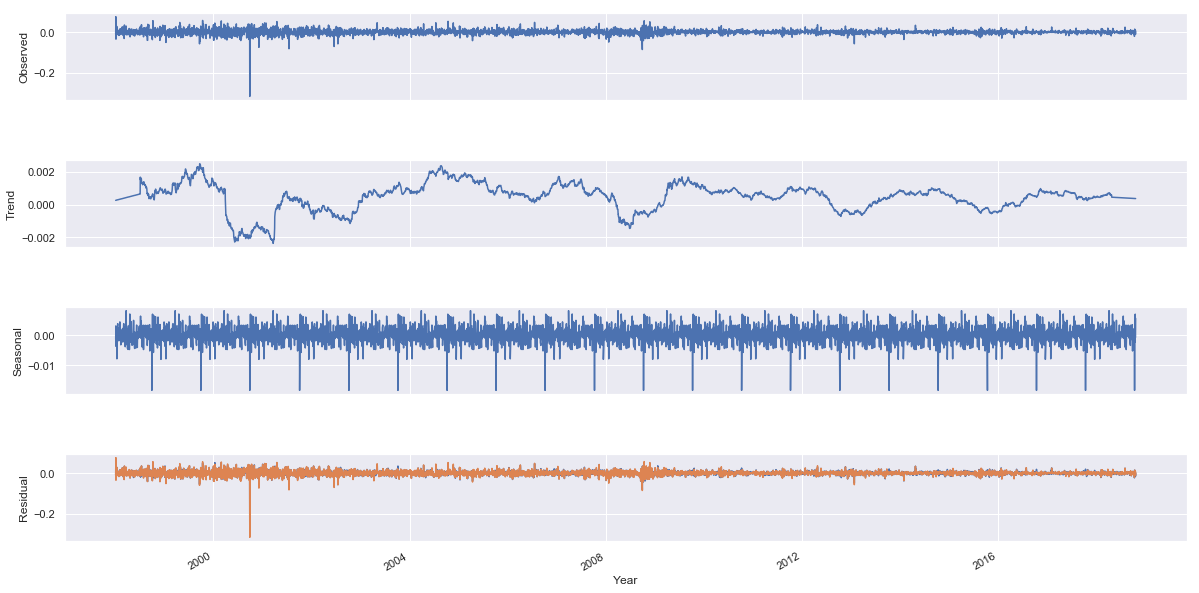

In [99]:
# df = stocks
# decomposition_param = 'ADJ_CLOSE'

df = stock_returns
# df = std_scaled_stock_returns
# df = minmax_scaled_stock_returns
decomposition_param = 'RETURNS'

# df = min_max_scaling_data(stock_returns, 1, 2)

# Additive Decomposition using statsmodel seasonal decompose
print('Additive Decomposition:')    
add_decom = series_decomposition(df, 'additive', decomposition_param)
print('Additive: Seasonlity and Residue')
(add_decom.seasonal + add_decom.resid).plot(figsize=(20,10))
plt.show()

# Multiplicative Decomposition using statsmodel seasonal decompose
# print('Multiplicative Decomposition:')    
# mult_decom = series_decomposition(df, 'multiplicative', decomposition_param)
# print('Multiplicative: Seasonlity and Residue')
# (mult_decom.seasonal*mult_decom.resid).plot()
# plt.show()

## Data Properties

### 1. Autocorrelation
**Autocorrelation** is the correlation of a signal with a delayed copy of itself

In [18]:
# This function takes in a dataframe and the index of a column to plot the autocorrelation
def plot_autocorrelation(df, decomposition_param_index):
    # Printing autocorrelation for a particular lag value
    lag = 1
    print('Lag:', lag, '\t autocorrelation:', df.iloc[:, decomposition_param_index].diff().autocorr(lag=lag))
    
    plt.figure(figsize=(20,10))
    pd.plotting.autocorrelation_plot(df.iloc[:, decomposition_param_index])
    plt.title('Autocorrelation Plot', fontsize=20);

Lag: 1 	 autocorrelation: -0.5215891206731078


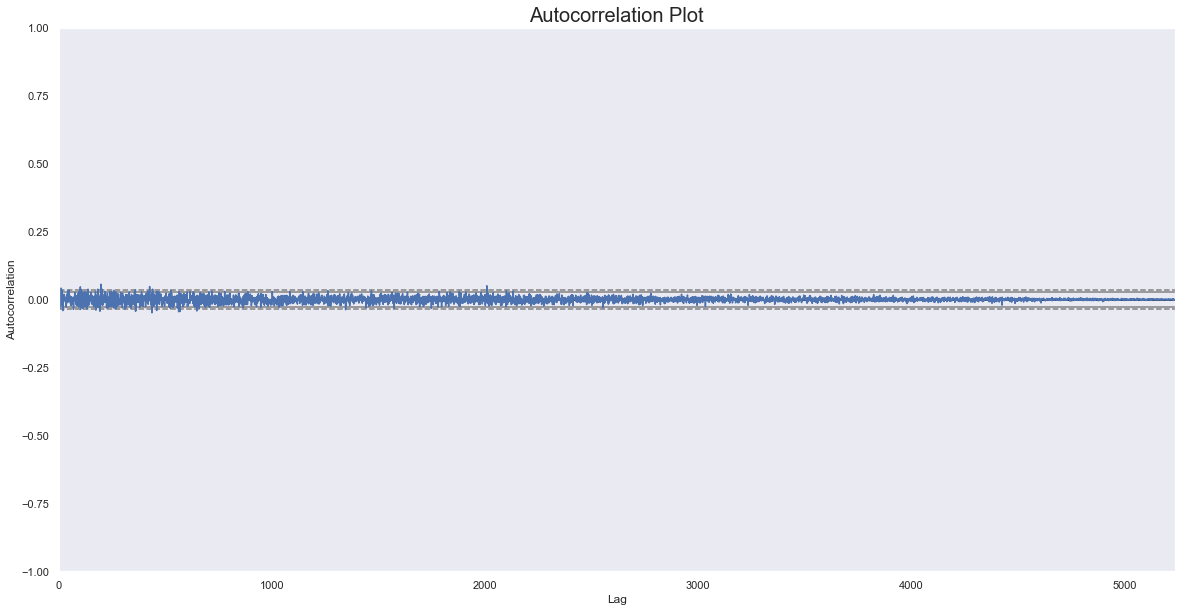

In [41]:
# df = stocks
# decomposition_param = 'ADJ_CLOSE'
# decomposition_param_index = 4

# df = stock_returns
# print(stock_returns.head())
df = std_scaled_stock_returns
# df = minmax_scaled_stock_returns
# decomposition_param = 'RETURNS'
decomposition_param_index = 0

plot_autocorrelation(df, decomposition_param_index)

### 2. Distribution

In [20]:
# TODO plot the absolute values of returns on the log-log scale
# This function compares the data distribution to normal distribution
def plot_distribution(data, distribution='cdf'):
    # Get parameters of normal distribution i.e the mean and the variance:
    mu = 0
    variance = 1
    sigma = math.sqrt(variance)

    if distribution == 'cdf':
        # Plot the histogram.
        data.hist(bins=100, density=True, alpha=0.6, cumulative = True)
        
        # Plot the CDF.
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#         plt.plot(x, sp.stats.norm.cdf(x, mu, sigma))
        plt.semilogy(x, sp.stats.norm.cdf(x, mu, sigma))
    elif distribution == 'pdf':
        # Plot the histogram.
        data.hist(bins=100, density=True, alpha=0.6, cumulative = False)
        
        # Plot the PDF.
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#         plt.plot(x, sp.stats.norm.pdf(x, mu, sigma))
        plt.semilogy(x, sp.stats.norm.pdf(x, mu, sigma))
        
    # plt.yscale("log")
    # plt.xscale("log")
    plt.title("Returns vs Normal Distribution")
    plt.show()

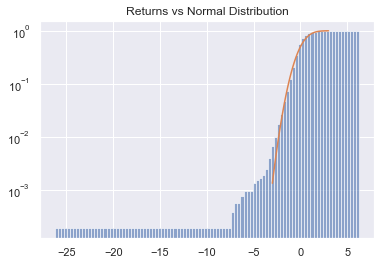

In [42]:
# Generate some data for plotting the data distribution
data = std_scaled_stock_returns
plot_distribution(data, distribution='cdf')

### 3. Kurtosis and Skew
https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm  

**Skewness** is usually described as a measure of a dataset’s symmetry – or lack of symmetry.   A perfectly symmetrical data set will have a skewness of 0. The normal distribution has a skewness of 0.  
https://www.spcforexcel.com/knowledge/basic-statistics/are-skewness-and-kurtosis-useful-statistics#skewness  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html  
  
**Kurtosis** is all about the tails of the distribution – not the peakedness or flatness.  It measures the tail-heaviness of the distribution. The normal distribution has a kurtosis of 0.  
(Kurtosis is the degree of peakedness of a distribution – Wolfram MathWorld)  
https://www.spcforexcel.com/knowledge/basic-statistics/are-skewness-and-kurtosis-useful-statistics#kurtosis  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html

In [22]:
# This function prints the skewness and kurtosis for the given data frame 
def skewness_kurtosis(df):
    print("Skewness: ", sp.stats.skew(df))
    print("Kurtosis: ", sp.stats.kurtosis(df))

In [43]:
skewness_kurtosis(std_scaled_stock_returns)

Skewness:  [-3.48752774]
Kurtosis:  [93.46163613]


### 4. Volatility
https://www.packtpub.com/mapt/book/big_data_and_business_intelligence/9781787123137/15/ch15lvl1sec133/calculating-the-volatility-of-stocks

In [24]:
# This function takes in the dataframe, a parameter and the window frame
# The function calculates the volatility of the parameter specified within a
# given time window and plots the volatility of the parameter over the course of the data
def plot_volatility_curve(df, param, window = 252):
    vol = df[decomposition_param].rolling(window=window).std() * np.sqrt(window)
    vol.plot(figsize=(20, 10))

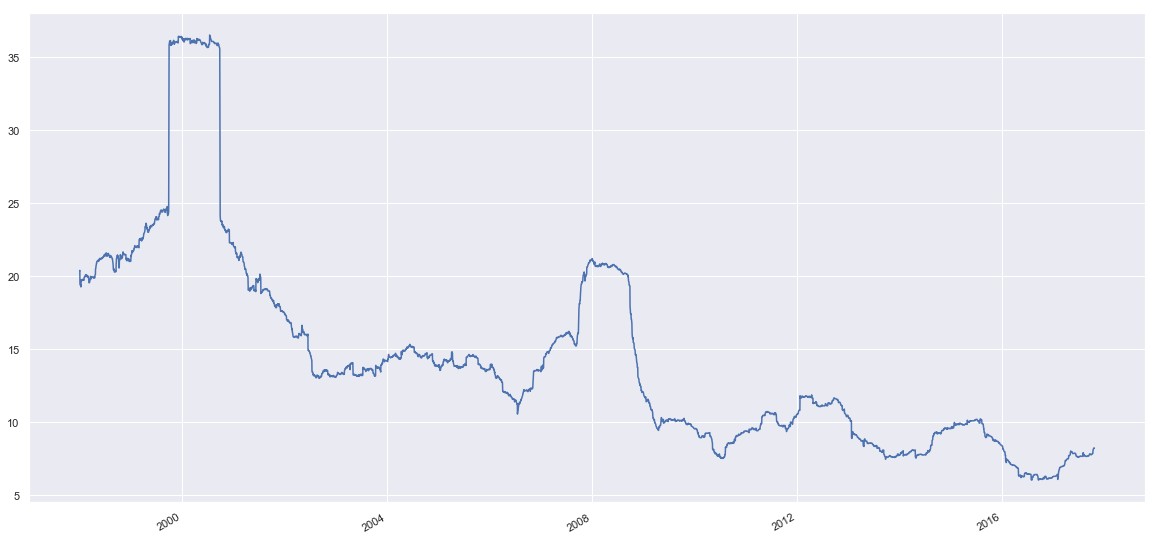

In [44]:
# df = stocks
# decomposition_param = 'ADJ_CLOSE'

# df = stock_returns
df = std_scaled_stock_returns
# df = minmax_scaled_stock_returns
decomposition_param = 'RETURNS'

plot_volatility_curve(df, decomposition_param, window = 252)

### 5. P-Dickey Fuler Test
https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

In [98]:
# This function implements the Rolling Mean and Augmented Dickey-Fuller test for stationarity
def test_stationarity(df, decomposition_param='RETURNS', window = 252):
    # Determing rolling statistics 
    rolmean = df[decomposition_param].rolling(window).mean()
    rolstd = df[decomposition_param].rolling(window).std()
    
    plt.figure(figsize=(20,10))
    
    # Plot rolling statistics:
    orig = plt.plot(df[decomposition_param], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[decomposition_param], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

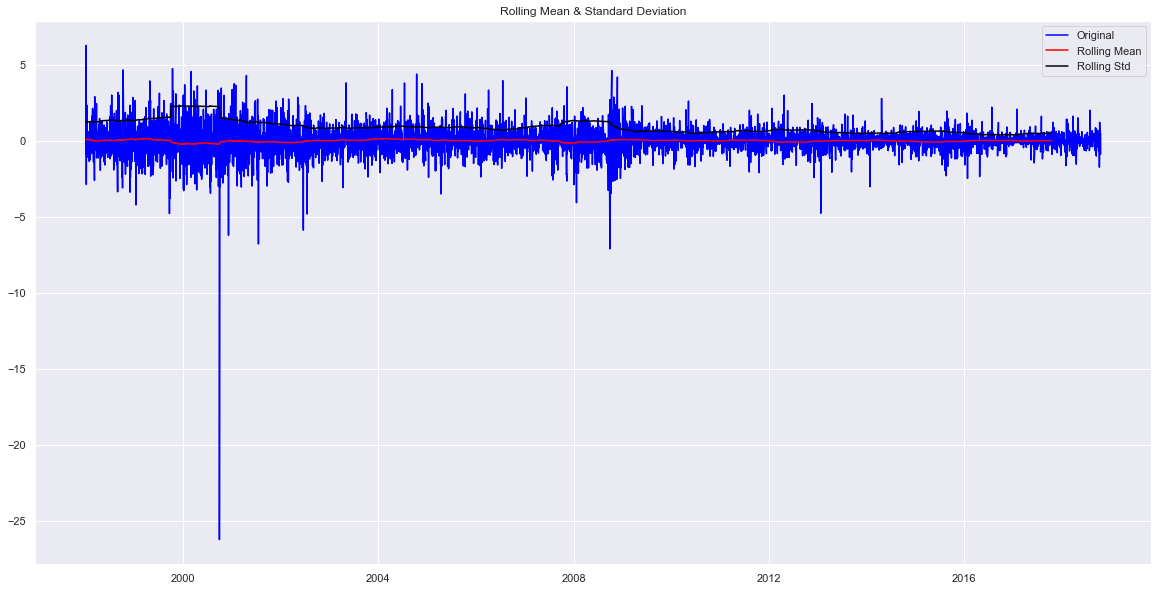

Results of Dickey-Fuller Test:
Test Statistic                   -5.270024
p-value                           0.000006
#Lags Used                       31.000000
Number of Observations Used    5203.000000
Critical Value (1%)              -3.431607
Critical Value (5%)              -2.862096
Critical Value (10%)             -2.567066
dtype: float64


In [96]:
test_stationarity(std_scaled_stock_returns, 'RETURNS')

1. plot the absolute values of returns on the log-log scale  
2. pdf and cdf
3. p-Dickey Fuller Test 
4. Implement algorithms